In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import functions as func
from radar_functions import *

from tqdm.autonotebook import tqdm
import emcee
import corner
from multiprocessing import Pool
from skimage.metrics import structural_similarity as ssim
import cv2

/tmp/ipykernel_1576004/2352129675.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def ln_posterior_radar(params: tuple, radar_image_params: RadarImageParameters, radar_images: list, position_vecs):
    """
    calculates chi2 for the modeled lightcurve with the given parameters
    """
    mult = 450
    parameters = Parameters(a1=params[0] * mult, b1=params[1] * mult, c1=params[2] * mult,
                            a2=params[3] * mult, b2=params[4] * mult, c2=params[5] * mult,
                            l=params[6], b=params[7], phi0=params[8])
    #number of points in latitude and longitude used in ray tracing
    cosl = math.cos(parameters.l)
    sinl = math.sin(parameters.l)
    cosb = math.cos(parameters.b)
    sinb = math.sin(parameters.b)
    primary = Ellipsoid(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    *parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
    secondary = Ellipsoid(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      *parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))
    diff_total = []
    #subplot(r,c) provide the no. of rows and columns
    for idx_img in range(radar_image_params.N_points):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images[idx_img]
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                        secondary=secondary,
                                                                        ex=ex, ey=ey, ez=ez,
                                                                        P=parameters.P, 
                                                                        N_radar_pixels=radar_image_params.size_px[idx_img],
                                                                        dr=radar_image_params.dr[idx_img], 
                                                                        dnu=radar_image_params.dnu[idx_img], Nalpha=30)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = scipy.ndimage.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = scipy.ndimage.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            try:
                theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
                theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            except:
                continue
            # calculate difference between theoretical and observed images
            diff = img_difference(observed_radar_brightness, theoretical_radar_brightness)
            diff_total.append(diff)
    
    chi2 = np.sum(np.array(diff_total))
    return -0.5 * chi2

def images_diff(params: tuple, radar_image_params: RadarImageParameters, radar_images: list, position_vecs, mult=400):
    """
    calculates chi2 for the modeled lightcurve with the given parameters
    """
    parameters = Parameters()
    parameters.a1 = params[0] * mult
    parameters.b1 = params[1] * mult
    parameters.c1 = params[2] * mult
    parameters.a2 = params[3] * mult
    parameters.b2 = params[4] * mult
    parameters.c2 = params[5] * mult
    parameters.l = params[6]
    parameters.b = params[7] 
    parameters.phi0 = params[8] 
    #number of points in latitude and longitude used in ray tracing
    cosl = math.cos(parameters.l)
    sinl = math.sin(parameters.l)
    cosb = math.cos(parameters.b)
    sinb = math.sin(parameters.b)
    primary = Ellipsoid(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    *parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
    secondary = Ellipsoid(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      *parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))
    imgs = []
    diff_total = []
    #subplot(r,c) provide the no. of rows and columns
    for idx_img in range(radar_image_params.N_points):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images[idx_img]
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                        secondary=secondary,
                                                                        ex=ex, ey=ey, ez=ez,
                                                                        P=parameters.P, 
                                                                        N_radar_pixels=radar_image_params.size_px[idx_img],
                                                                        dr=radar_image_params.dr[idx_img], 
                                                                        dnu=radar_image_params.dnu[idx_img], Nalpha=30)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = scipy.ndimage.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = scipy.ndimage.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            # calculate difference between theoretical and observed images
            diff = img_difference(observed_radar_brightness, theoretical_radar_brightness)
            imgs.append((observed_radar_brightness-theoretical_radar_brightness))
            #sim = ssim(theoretical_radar_brightness, observed_radar_brightness, data_range=1)
            #sim_total.append(1 - sim)
            diff_total.append(diff)
    
    chi2 = np.sum(np.array(diff_total))
    print(-0.5 * chi2)
    return diff_total, imgs

def ln_prior(params: tuple) -> float:
    """constrains parameters to be in bounds, returns -inf if not in bounds,
    does not allow MCMC walkers to wander off"""
    a1, b1, c1, a2, b2, c2, lon, lat, init_phase = params
    # if any parameter is out of bounds, return -inf
    #a1_cond = 0.25 <= a1 <= 3
    b1_cond = 0.25 <= b1 <= a1
    c1_cond = 0.25 <= c1 <= b1
    a2_cond = 0.25 <= a2 <= a1
    b2_cond = 0.25 <= b2 <= a2
    c2_cond = 0.25 <= c2 <= b2
    lon_cond = 0 <= lon <= 2 * math.pi
    lat_cond = -math.pi/2 <= lat <= math.pi/2
    init_phase_cond = 0 <= init_phase <= 2 * math.pi
    if (b1_cond and c1_cond
            and a2_cond and b2_cond and c2_cond
            and lon_cond and lat_cond and init_phase_cond):
        return 0
    # if not, return -inf (this ensures walkers does not walk out of bounds)
    return -np.inf

def ln_prob(params, radar_image_list: RadarImageParameters, radar_images: list, position_vecs):
     """wrapper for ln posterior, returns chi2 if in bounds, else -inf"""
     ln_p = ln_prior(params)
     if not np.isfinite(ln_p):
         return -np.inf
     return ln_p + ln_posterior(params, radar_image_list, radar_images, position_vecs)

def denoise_img(img: np.array) -> np.array:
    """denoises image"""
    img = (img * 255).astype(np.uint8)
    dst = cv2.fastNlMeansDenoising(img, 20,20,5,21) / 255
    dst = dst - np.quantile(dst, 0.1) 
    dst[dst < 0] = 0
    dst = dst / np.max(dst)
    return dst

def saturate_theoretical_radar_image(brightness_list):
    N_radar_pixels = len(brightness_list)
    parameters.radar_saturation = 2000
    k = (1 - parameters.radar_background) / parameters.radar_saturation
    b = parameters.radar_background
    for i in range(N_radar_pixels):
        for j in range(N_radar_pixels):
            if brightness_list[i][j] > parameters.radar_saturation:
                brightness_list[i][j] = parameters.radar_saturation
            brightness_list[i][j] = k*brightness_list[i][j] + b
    return brightness_list

def img_difference(observed, theoretical):
    return np.sum((observed - theoretical)**2, axis=None)

In [3]:
nu0 = 8560000000. # radar frequency 
c = 299792458.
deg = math.pi/180

In [4]:
radar_image_params = RadarImageParameters(file_name="Radar/data.txt")
radar_images_obs = [np.array(read_observed_radar_image(radar_image_params, idx_img)) for idx_img in range(radar_image_params.N_points)]

query_dates = [radar_image_params.jd[idx_img] + 2400000.5 for idx_img in range(len(radar_image_params.jd))]
state_vecs_earth = func.get_object_orbit('2000 WO107', epochs=query_dates,  location='@399', data_type='vectors')
state_vecs_earth['r'] = np.sum(state_vecs_earth[['x', 'y', 'z']] ** 2, axis=1)**0.5
position_vecs = (state_vecs_earth[['x', 'y', 'z']].T / state_vecs_earth['r']).T

In [8]:
to_m = 300
best_params = [1.51125587,  1.04818451,  1.04702347,  0.87205998,  1.15514118,  0.86929103, 0.102398, -1.13466942, 0.38890553]
best_params = [1, 0.426, 0.267, 0.541, 0.539, 0.539, 5.013, -1.349, 5.425] # new constrain (10k samples)
parameters = Parameters()
parameters.a1 = best_params[0] * to_m
parameters.b1 = best_params[1] * to_m
parameters.c1 = best_params[2] * to_m
parameters.a2 = best_params[3] * to_m
parameters.b2 = best_params[4] * to_m
parameters.c2 = best_params[5] * to_m
parameters.l = best_params[6]
parameters.b = best_params[7]
parameters.phi0 = best_params[8]

# define primary and secondary ellipsoids of the binary 
primary = Ellipsoid(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    * parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
secondary = Ellipsoid(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      * parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))

#number of points in latitude and longitude used in ray tracing
Nalpha = 50
dalphadbeta = math.pi**2/Nalpha**2

cosl = math.cos(parameters.l)
sinl = math.sin(parameters.l)
cosb = math.cos(parameters.b)
sinb = math.sin(parameters.b)

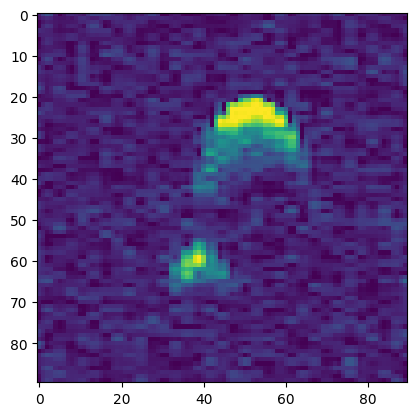

In [9]:
plt.imshow(radar_images_obs[0])

0.0 1.0


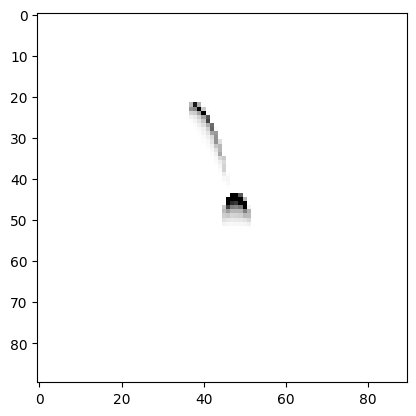

In [10]:
idx_img = 0
phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
sinphi = math.sin(phi)
cosphi= math.cos(phi)
ex0 = position_vecs['x'].iloc[idx_img]
ey0 = position_vecs['y'].iloc[idx_img]
ez0 = position_vecs['z'].iloc[idx_img]
ex,ey,ez = rotate(ex0,ey0,ez0,sinl,cosl,sinb,cosb,sinphi,cosphi)
brightness_radar = theoretical_radar_image(primary, secondary, ex0, ey0, ez0, parameters.P, 
                                           N_radar_pixels=radar_image_params.size_px[idx_img], 
                                           dr=radar_image_params.dr[idx_img], 
                                           dnu=radar_image_params.dnu[idx_img], 
                                           Nalpha=50)

saturate_theoretical_radar_image(brightness_radar)
brightness_radar = np.array(brightness_radar) - 0.1
brightness_radar /= np.max(brightness_radar)
plt.imshow(brightness_radar, cmap='gray_r', interpolation='nearest')
print(np.array(brightness_radar).min(), np.array(brightness_radar).max())

38.227680384746925 44.945294038250175 
 42.95263250431559 45.61537785307845
4.724952119568663 0.6700838148282742


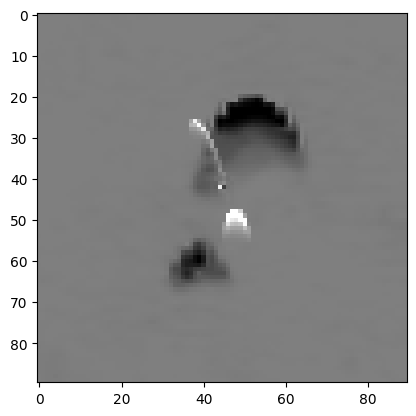

In [142]:
theoretical_radar_brightness = np.array(brightness_radar) 
x_center_theor, y_center_theor = scipy.ndimage.center_of_mass(theoretical_radar_brightness)
x_center_obs, y_center_obs = scipy.ndimage.center_of_mass(radar_images_obs[idx_img])
radar_images_obs[idx_img][int(x_center_obs), int(y_center_obs)] = 1
theoretical_radar_brightness[int(x_center_theor), int(y_center_theor)] = 1
print(x_center_theor, y_center_theor, '\n',x_center_obs, y_center_obs)
shift_x = x_center_obs - x_center_theor
shift_y = y_center_obs - y_center_theor
print(shift_x, shift_y)

# shift theoretical image
theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)

diff = denoise_img(radar_images_obs[idx_img]) - theoretical_radar_brightness
plt.imshow(diff, cmap='gray_r', interpolation='nearest')

In [11]:
radar_image_params = RadarImageParameters(file_name="Radar/data.txt")
# radar_images_obs = [np.array(read_observed_radar_image(radar_image_params,idx_img)) for idx_img in range(radar_image_params.N_points)]
radar_images_obs = [denoise_img(np.array(read_observed_radar_image(radar_image_params,idx_img))) 
                    for idx_img in range(radar_image_params.N_points)]


query_dates = [radar_image_params.jd[idx_img] + 2400000.5 for idx_img in range(len(radar_image_params.jd))]
state_vecs_earth = func.get_object_orbit('2000 WO107', epochs=query_dates,  location='@399', data_type='vectors')
state_vecs_earth['r'] = np.sum(state_vecs_earth[['x', 'y', 'z']] ** 2, axis=1)**0.5
position_vecs = (state_vecs_earth[['x', 'y', 'z']].T / state_vecs_earth['r']).T

In [5]:
n_procs = 12  # number of processes (cores) to use
nwalkers = n_procs * 3  # number of probe points

coeff = 0.2
init_ps = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0]
init_params = np.array([init_ps[0]  + coeff * np.random.randn(nwalkers),  # b1
                        init_ps[1]  + coeff * np.random.randn(nwalkers),  # c1
                        init_ps[2]  + coeff * np.random.randn(nwalkers),  # a2
                        init_ps[3]  + coeff * np.random.randn(nwalkers),  # b2
                        init_ps[4]  + coeff * np.random.randn(nwalkers),  # c2
                        init_ps[5]  + coeff * np.random.randn(nwalkers),  # c2
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers), 
                        0 + np.random.uniform(low=-math.pi /2, high=math.pi /2, size=nwalkers), 
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers)]).T
ndim = np.size(init_params, axis=1)  # number of parameters
init_params = init_params.astype(float)

with Pool(processes=n_procs) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                    args=(radar_image_params, radar_images_obs, position_vecs), 
                                    pool=pool)
    # Run the MCMC sampler
    nsteps = 10
    burn_in = 1
    sampler.run_mcmc(init_params, nsteps, progress=True)
    # Get the samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)

  0%|          | 0/10 [00:00<?, ?it/s]/home/igor/anaconda3/envs/sandbox/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 70%|███████   | 7/10 [00:02<00:00,  3.41it/s]

emcee: Exception while calling your likelihood function:
  params: [ 1.17088682  1.0078503   0.90824497  1.10860462  0.96141991  0.93098142
  4.42102839 -0.71460487  3.68141019]
  args: (<radar_functions.RadarImageParameters object at 0x7f46a9adb410>, [array([[0.08627451, 0.19607843, 0.25490196, ..., 0.06666667, 0.05882353,
        0.06666667],
       [0.05490196, 0.09803922, 0.12156863, ..., 0.05490196, 0.04705882,
        0.00392157],
       [0.        , 0.05882353, 0.09019608, ..., 0.08627451, 0.07843137,
        0.0745098 ],
       ...,
       [0.05882353, 0.11764706, 0.14901961, ..., 0.02745098, 0.03529412,
        0.01568627],
       [0.02745098, 0.11764706, 0.14901961, ..., 0.1254902 , 0.08627451,
        0.        ],
       [0.01568627, 0.12941176, 0.17647059, ..., 0.20392157, 0.15686275,
        0.0627451 ]]), array([[0.13333333, 0.17647059, 0.18039216, ..., 0.0627451 , 0.08235294,
        0.09019608],
       [0.0745098 , 0.08627451, 0.09803922, ..., 0.07058824, 0.10588235,
  

Traceback (most recent call last):
  File "/home/igor/anaconda3/envs/sandbox/lib/python3.12/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1576004/360710253.py", line 167, in ln_prob
    return ln_p + ln_posterior(params, radar_image_list, radar_images, position_vecs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1576004/360710253.py", line 52, in ln_posterior
    saturate_theoretical_radar_image(theoretical_radar_brightness_list)
  File "/tmp/ipykernel_1576004/360710253.py", line 180, in saturate_theoretical_radar_image
    parameters.radar_saturation = 2000
    ^^^^^^^^^^
NameError: name 'parameters' is not defined. Did you mean: 'Parameters'?
 70%|███████   | 7/10 [00:02<00:01,  2.85it/s]


NameError: name 'parameters' is not defined

In [169]:
# import pickle
# file_pick = open('binary_sampler.obj', 'wb')
# pickle.dump(sampler, file=file_pick)

In [42]:
import pickle
file_pick = open('radar_sampler_28_08.obj', 'rb')
sampler = pickle.load(file_pick)

In [43]:
samples_flat = sampler.flatchain
samples = sampler.get_chain(flat=True)[int(len(samples)*0.25):]
flat_ln = sampler.flatlnprobability #[np.isfinite(sampler.flatlnprobability)]
min_arg = flat_ln.argmax()
min_chi = flat_ln[min_arg]
print(f"min_arg: {min_arg}, min_chi: {min_chi}")
best_params = samples_flat[min_arg]
print(np.shape(samples))

print("""best_params: a1 = 1.0  b1 = {:.2f}, c1 = {:.2f},
             a2 = {:.2f}, b2 = {:.2f}, c2 = {:.2f}, 
             lon = {:.2f}, lat = {:.2f}, phase = {:.2f}""".format(*best_params))
print([round(i, 2) for i  in best_params])

# # Calculate the quantile
# quant = 0.5
# threshold = np.quantile(flat_ln, q=quant)
# print(f"threshold q={quant}: ln_posterior = {threshold}")
# # Get the indices of the values that are in the specified quantile
# indices = np.where(flat_ln >= threshold)[0]
# # calculate best-fit parameters as a median of q=0.95 least chi2 results 
# #best_med_params = np.median(samples_flat[indices], axis=0)
# best_med_params = samples_flat[indices][0]
# best_params = samples_flat[min_arg]
# 
# print("""best_params: a1 = 1.0  b1 = {:.2f}, c1 = {:.2f},
#              a2 = {:.2f}, b2 = {:.2f}, c2 = {:.2f}, 
#              lon = {:.2f}, lat = {:.2f}, phase = {:.2f}""".format(*best_params))
# best_params = np.insert(best_params, 0, 1.0)
# best_med_params = np.insert(best_med_params, 0, 1.0)
# best_params_list = list(best_params)
# best_params_list = [round(param, 3) for param in best_params_list]
# best_med_params_list = [round(param, 3) for param in best_med_params]
# print('best:      ', best_params_list)
# print(f'best q={quant}:', best_med_params_list)

min_arg: 242052, min_chi: -2695.1054357468197
(359931, 9)
best_params: a1 = 1.0  b1 = 1.00, c1 = 0.97,
             a2 = 0.82, b2 = 0.65, c2 = 0.65, 
             lon = 0.50, lat = 2.58, phase = -1.33
[1.0, 0.97, 0.82, 0.65, 0.65, 0.5, 2.58, -1.33, 2.91]


In [44]:
# output 1 sigma percentiles for all parameters
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]}: {mcmc[1]:.3f} -{q[0]:.3f} +{q[1]:.3f}")

a1: 1.207 -0.395 +0.205
b1: 1.036 -0.064 +0.062
c1: 0.827 -0.570 +0.258
a2: 1.012 -0.346 +0.105
b2: 0.996 -0.330 +0.154
c2: 0.623 -0.370 +0.360
l: 2.814 -1.348 +1.868
b: 1.031 -2.346 +0.374
phi0: 4.157 -1.346 +1.329


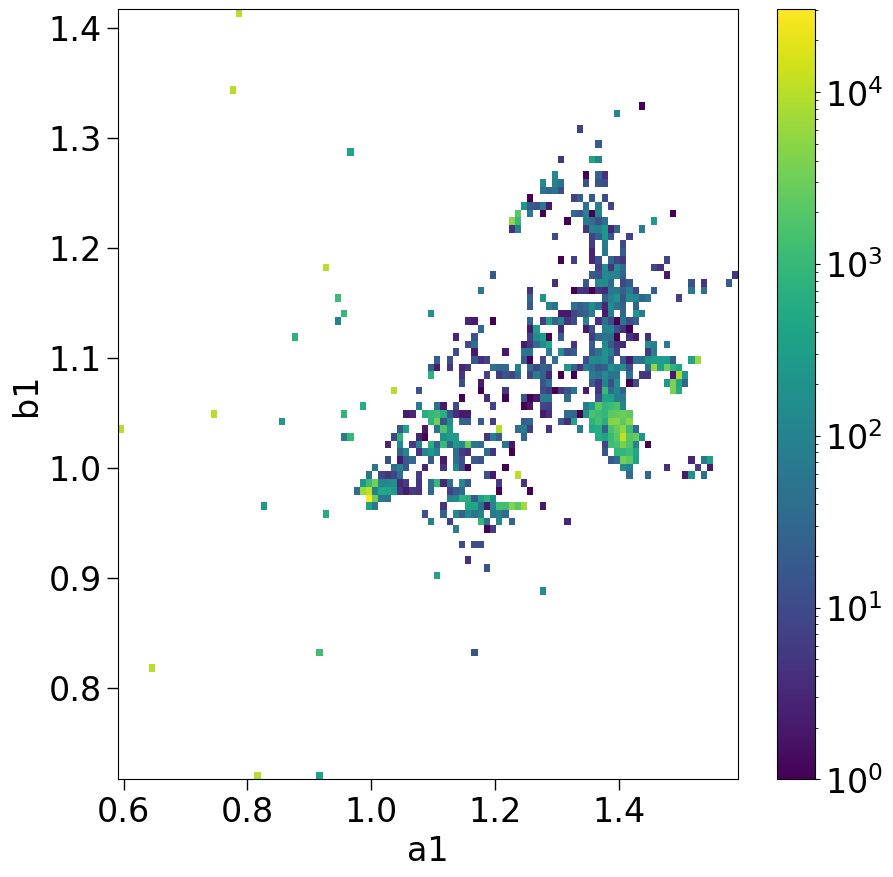

In [46]:
from matplotlib.colors import LogNorm

#plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.tick_params(axis='both', which='major', width=1, length=8)
ax.tick_params(axis='both', which='minor', width=1, length=6)
#plt.title("eccentricity distribution")
ax.set_xlabel('a1', fontsize=24)
ax.set_ylabel('b1', fontsize=24)
plt.hist2d(samples[:, 0], samples[:, 1], bins=100, norm=LogNorm())
plt.colorbar()


/tmp/ipykernel_1544512/3583923755.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.5)


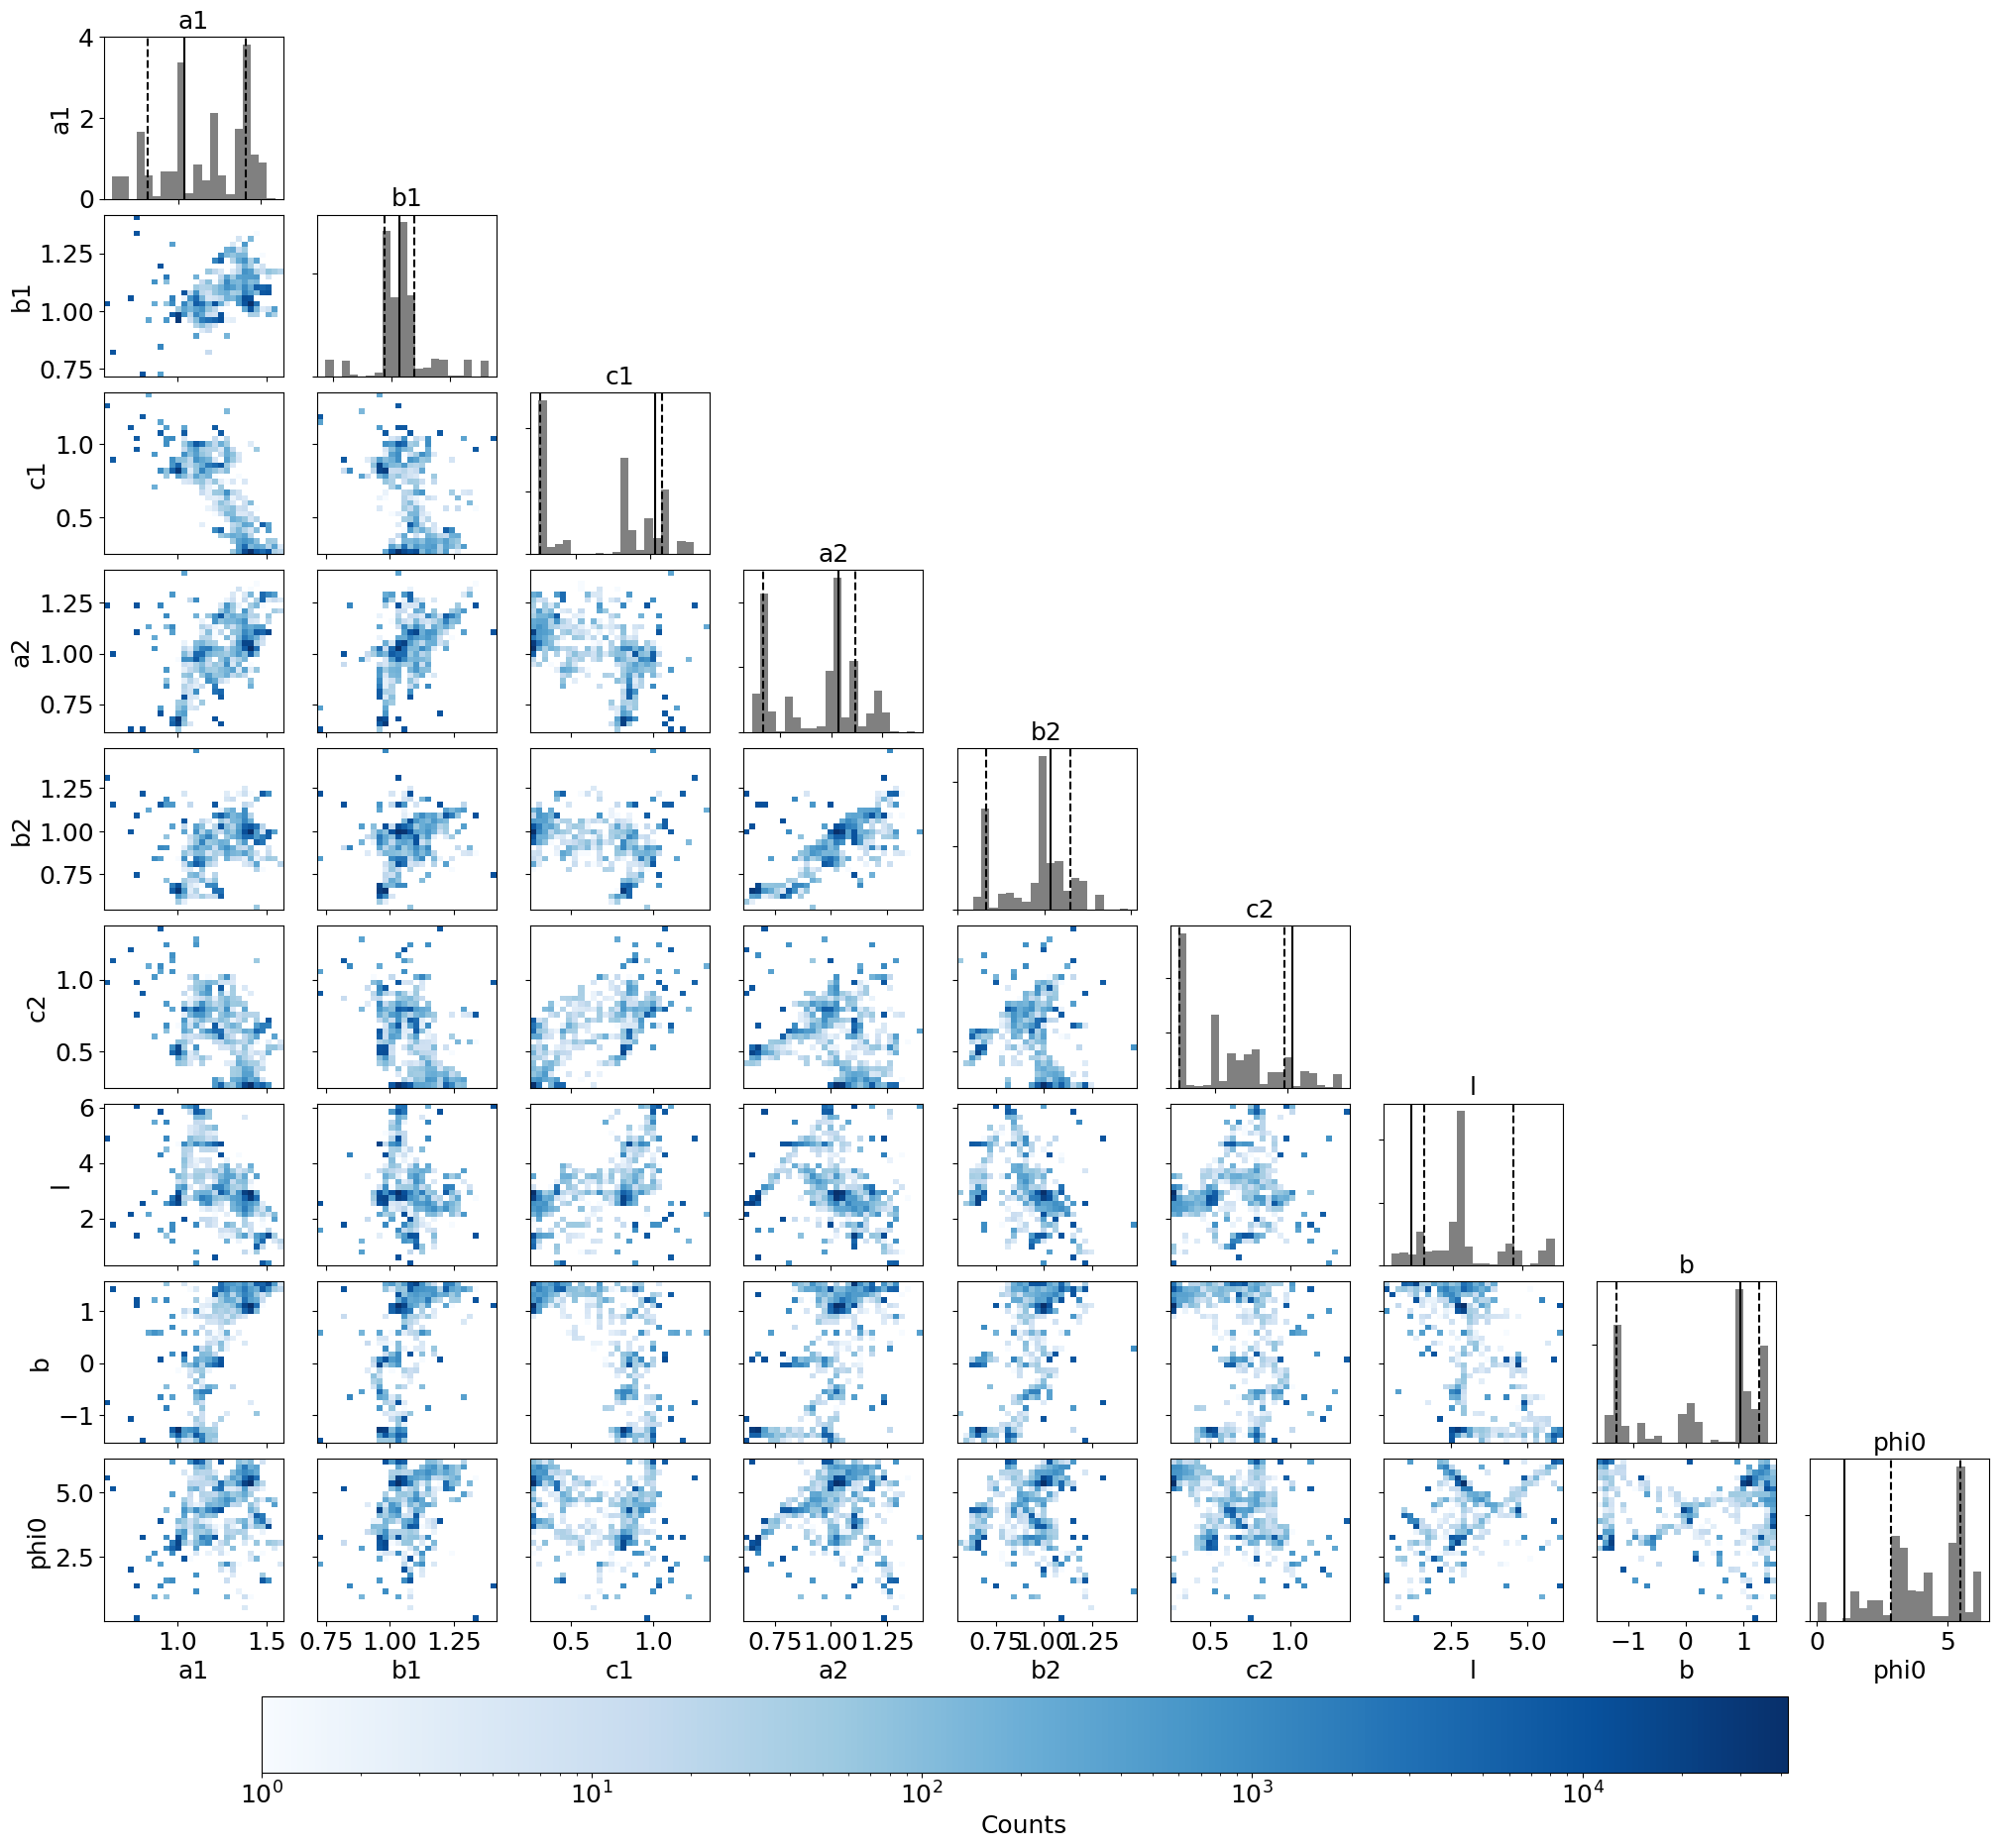

In [49]:
# Number of parameters
from matplotlib.colors import LogNorm
data = samples
num_params = data.shape[1]
labels=["a1", "b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"]

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
# Create a figure with subplots
fig, axes = plt.subplots(num_params, num_params, figsize=(20, 20), dpi=100)
bins_heat = 30
bins_hist = 20

# Variable to store the mappable object for the colorbar
mappable = None
# Plot the histograms and scatter plots
for i in range(num_params):
    for j in range(num_params):
        if i < j:
            # Skip the upper triangle and diagonal
            axes[i, j].axis('off')
        elif i == j:
            # Diagonal: plot histograms
            axes[i, j].hist(data[:, i], bins=bins_hist, color='gray', density=True)
            p16 = np.percentile(data[:, i], 16)
            p84 = np.percentile(data[:, i], 84)
            median = np.median(data)
            axes[i, j].axvline(median, color='black')
            axes[i, j].axvline(p16, color='black', linestyle='--')
            axes[i, j].axvline(p84, color='black', linestyle='--')
            # Add title with median and percentiles
            # axes[i, j].title.set_text(r'{0}=${1}^{2}$_{3}$'.format(labels[i], 
            #                                                        round(median,2), round(p16, 2), round(p84, 2)))
            axes[i, j].title.set_text(labels[i])
        else:
            # Off-diagonal: plot scatter plots
            h = axes[i, j].hist2d(data[:, j], data[:, i], bins=bins_heat, cmap='Blues', norm=LogNorm())
            if mappable is None:
                mappable = h[3]  # Store the mappable object for the colorbar
            #axes[i, j].set_xlabel(labels[j])
           
        # Remove labels for cleaner look
        if i < num_params - 1:
            axes[i, j].set_xticklabels([])
        if j > 0:
            axes[i, j].set_yticklabels([])
        
        # Add axis labels
        if i == num_params - 1:
            axes[i, j].set_xlabel(labels[j])
        if j == 0:
            axes[i, j].set_ylabel(labels[i])


# Add a colorbar at the bottom for all subplots
if mappable:
    cbar = fig.colorbar(mappable, ax=axes, orientation='horizontal', fraction=0.05, pad=-0.25, shrink=2.0)
    cbar.set_label('Counts')

# Adjust layout
plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.5)
plt.show()

Text(0.5, 0.98, 'Corner diagram')

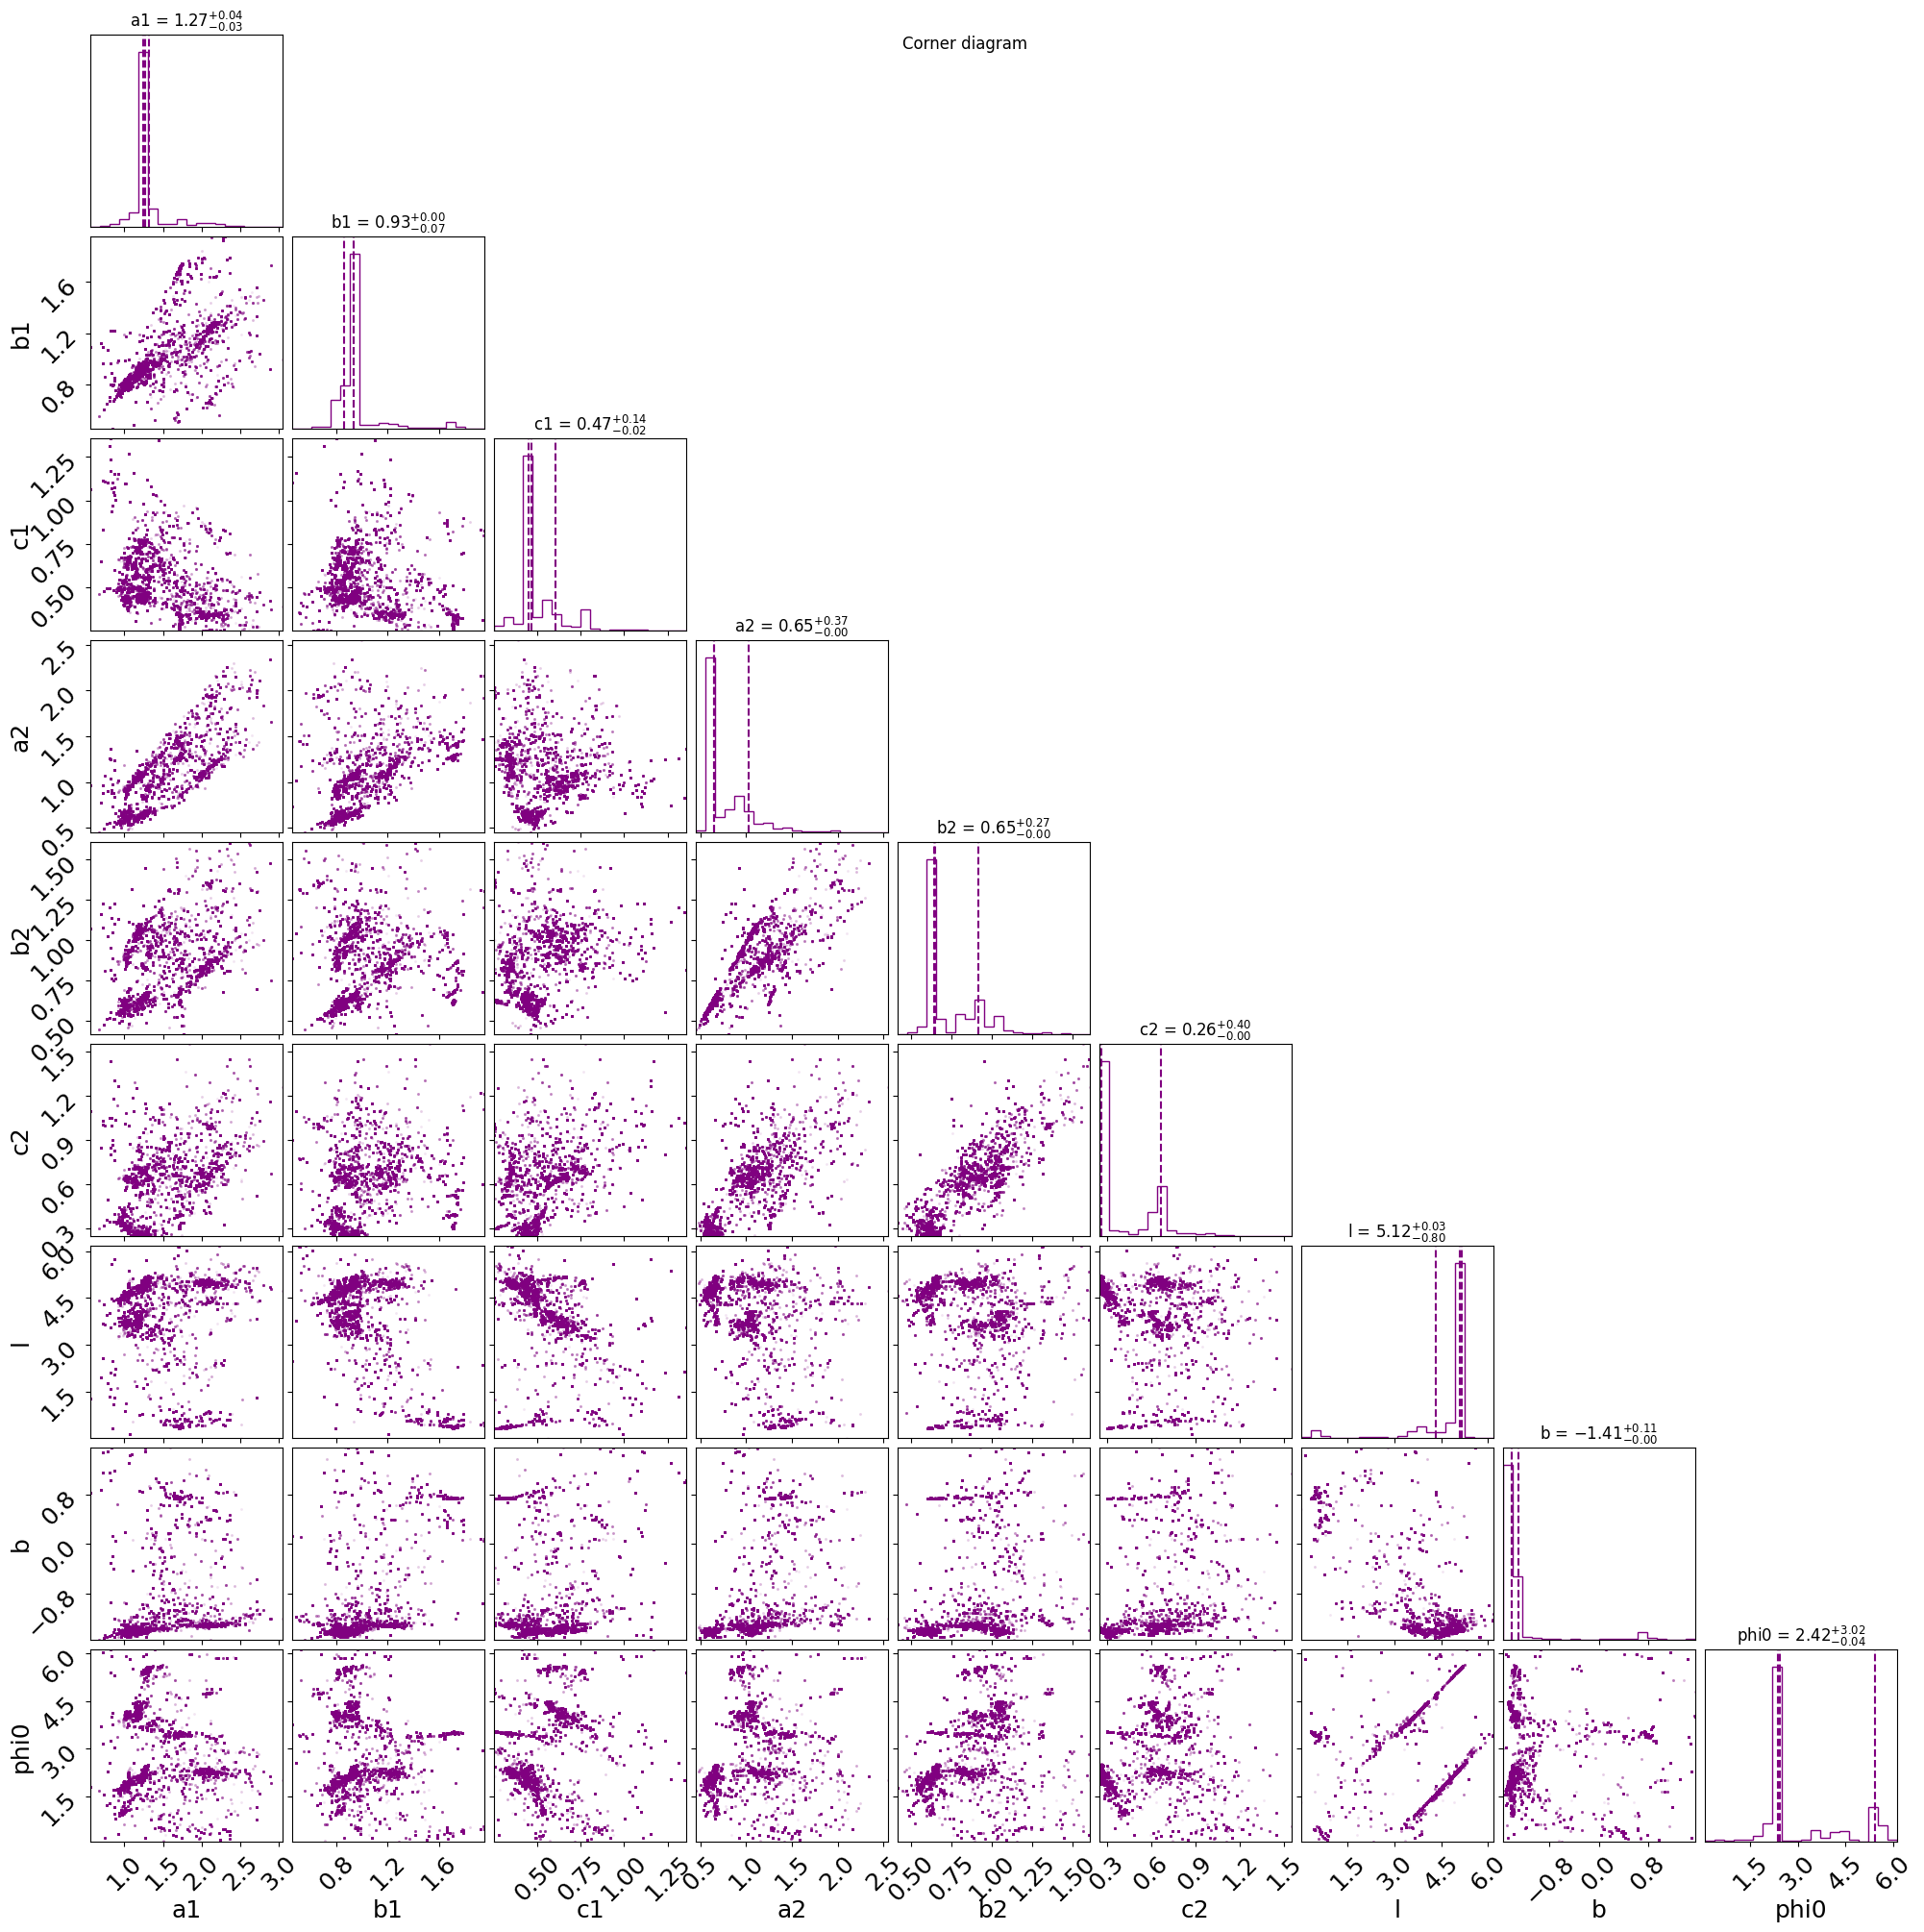

In [11]:
# Plot the corner plot
corner_fig = corner.corner(samples, labels=["a1", "b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"],
                           quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, 
                           plot_contours=False, fill_contours=False, plot_density=False, color="purple", levels=(0.68,), title_fmt=".2f")
plt.suptitle("Corner diagram") 

In [27]:
func.estimate_density(1.24, 0.81, 0.76, 0.83, 0.83, 0.7, rot_per=5.022)

5.341218194743762

(array([0.12213001, 0.27915432, 0.        , 0.26170717, 0.26170717,
        0.27915432, 0.40128433, 0.54086149, 0.54086149, 0.27915432,
        0.52341434, 0.27915432, 0.22681288, 0.41873147, 0.1570243 ,
        0.1570243 , 0.        , 0.        , 0.        , 0.13957716]),
 array([1.1129813 , 1.31841488, 1.52384846, 1.72928204, 1.93471562,
        2.1401492 , 2.34558278, 2.55101635, 2.75644993, 2.96188351,
        3.16731709, 3.37275067, 3.57818425, 3.78361783, 3.98905141,
        4.19448499, 4.39991857, 4.60535215, 4.81078573, 5.01621931,
        5.22165289]),
 <BarContainer object of 20 artists>)

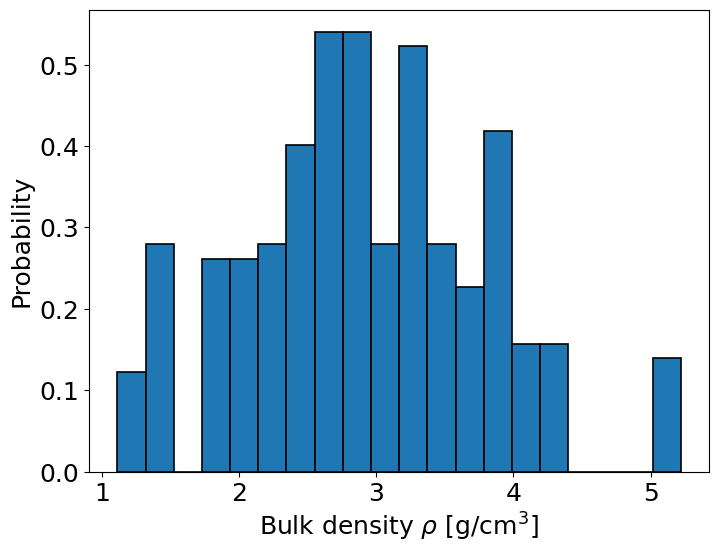

In [41]:
# calculate the density for the asteroid
density = func.estimate_density(*samples[:, :6].T, rot_per=5.022)
plt.figure(figsize=(8, 6))
plt.xlabel(r"Bulk density $\rho$ [g/cm$^3$]")
plt.ylabel("Probability")
plt.hist(density, bins=20, edgecolor='black', linewidth=1.2, density=True)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, HBox, VBox, widgets, Layout

# Define the function to update the plot
def interactive_plot(a1=1, b1=1, c1=1, a2=1, b2=1, c2=1, lon=0, lat=0, init_phase=0):
    parameters = Parameters()
    mult = 450
    parameters.a1 = a1 * mult
    parameters.b1 = b1 * mult
    parameters.c1 = c1 * mult
    parameters.a2 = a2 * mult
    parameters.b2 = b2 * mult
    parameters.c2 = c2 * mult
    parameters.l = lon
    parameters.b = lat
    parameters.phi0 = init_phase
     #number of points in latitude and longitude used in ray tracing
    cosl = math.cos(parameters.l)
    sinl = math.sin(parameters.l)
    cosb = math.cos(parameters.b)
    sinb = math.sin(parameters.b)
    primary = Ellipsoid(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    *parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
    secondary = Ellipsoid(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      *parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))
    imgs = []
    num_imgs = 5
    start = 60
    #subplot(r,c) provide the no. of rows and columns
    total_sim = 0
    for idx_img in range(start, start + num_imgs):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,sinl,cosl,sinb,cosb,sinphi,cosphi)
            observed_radar_brightness = radar_images_obs[idx_img]
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                        secondary=secondary,
                                                                        ex=ex, ey=ey, ez=ez,
                                                                        P=parameters.P, 
                                                                        N_radar_pixels=radar_image_params.size_px[idx_img],
                                                                        dr=radar_image_params.dr[idx_img], 
                                                                        dnu=radar_image_params.dnu[idx_img], Nalpha=30)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = scipy.ndimage.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = scipy.ndimage.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            #print(shift_x, shift_y)
            imgs.append([theoretical_radar_brightness, 
                         observed_radar_brightness, 
                         (observed_radar_brightness-theoretical_radar_brightness)])
            #print(img_difference(theoretical_radar_brightness, observed_radar_brightness))
            struct_sim = ssim(theoretical_radar_brightness, observed_radar_brightness, data_range=theoretical_radar_brightness.max() - theoretical_radar_brightness.min())
            #print(1 - struct_sim)
            total_sim += (1 - struct_sim)
            #print(struct_sim)
    
    fig, axarr = plt.subplots(3, num_imgs, figsize=(4 * num_imgs, 8))
    for idx_img in range(0, num_imgs):
        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        axarr[0][idx_img].imshow(imgs[idx_img][0], cmap='gray', interpolation='nearest')
        axarr[1][idx_img].imshow(imgs[idx_img][1], cmap='gray', interpolation='nearest')
        axarr[2][idx_img].imshow(imgs[idx_img][2], cmap='gray', interpolation='nearest')
    
    print('total similarity:', total_sim)
    #fig.show()
    
# best_params = [1.51125587,  1.04818451,  1.04702347,  0.87205998,  1.15514118,  0.86929103, 0.102398, -1.13466942, 0.38890553]
# best_params = [1.0, 0.619, 1.16, 0.484, 0.697, 0.799, 1.622, -1.245, 2.029] # mcmc_lc_15_08 (1k samples)
# #best_params = [1.0, 1.371, 1.71, 1.945, 1.204, 2.491, 5.103, -1.153, 2.394] # mcmc_lc_21_08 (10k samples)
# best_params = [1, 0.935, 1.577, 1.875, 0.697, 0.599, 0.868, -1.303, 4.401] # 2*axis constrain (1k samples)
# best_params = [1, 0.426, 0.267, 0.541, 0.539, 0.539, 5.013, -1.349, 5.425]# new constrain (10k samples)
# best_params = [1, 0.9, 0.8, 0.68, 0.67, 0.67, 5.08, -1.33, 5.49]
# best_params = [0.97, 0.78, 0.77, 0.65, 0.55, 0.54, 4.97, -1.23, 5.31]
#best_params = [1.244, 0.808, 0.762, 0.829, 0.829, 0.699, 5.055, -1.294, 5.475]
#best_params = [a1_slider.value, b1_slider.value, c1_slider.value, a2_slider.value, b2_slider.value, c2_slider.value,
#               lon_slider.value, round(lat_slider.value, 2), init_phase_slider.value]

width_sliders = Layout(width='400px')
# Create sliders
a1_slider = widgets.FloatSlider(value=best_params[0], min=0, max=3.0, step=0.01, description='a1', layout=width_sliders)
b1_slider = widgets.FloatSlider(value=best_params[1], min=0, max=3.0, step=0.01, description='b1', layout=width_sliders)
c1_slider = widgets.FloatSlider(value=best_params[2], min=0, max=3.0, step=0.01, description='c1', layout=width_sliders)
a2_slider = widgets.FloatSlider(value=best_params[3], min=0, max=3.0, step=0.01, description='a2', layout=width_sliders)
b2_slider = widgets.FloatSlider(value=best_params[4], min=0, max=3.0, step=0.01, description='b2', layout=width_sliders)
c2_slider = widgets.FloatSlider(value=best_params[5], min=0, max=3.0, step=0.01, description='c2', layout=width_sliders)
lon_slider = widgets.FloatSlider(value=best_params[6], min=0, max=np.pi * 2, step=0.01, description='lon', layout=width_sliders)
lat_slider = widgets.FloatSlider(value=best_params[7], min=-np.pi, max=np.pi, step=0.01, description='lat', layout=width_sliders)
init_phase_slider = widgets.FloatSlider(value=best_params[8], min=0, max=np.pi * 2, step=0.01, description='init_phase', layout=width_sliders)

# Group sliders in two columns
left_box = VBox([a1_slider, b1_slider, c1_slider, a2_slider, b2_slider, c2_slider])
right_box = VBox([lon_slider, lat_slider, init_phase_slider])


# Make interactive widget
ui = HBox([left_box, right_box])
out = interactive(interactive_plot, a1=a1_slider, b1=b1_slider, c1=c1_slider, a2=a2_slider, b2=b2_slider, c2=c2_slider, lon=lon_slider, lat=lat_slider, init_phase=init_phase_slider)
# # Display the interactive plot
display(ui, out.children[-1])

Output()

-2858.4887855996767
-3745.862753973991


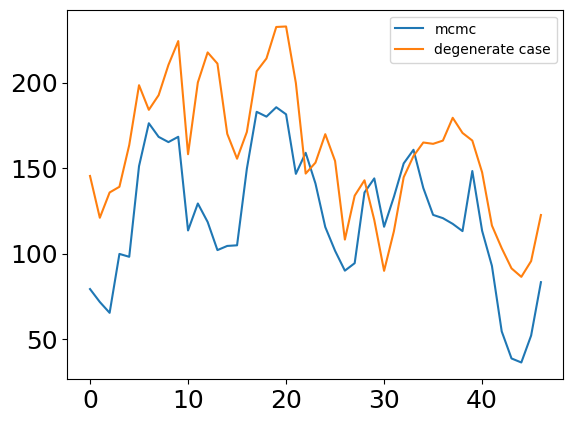

In [32]:
# best_params = [a1_slider.value, b1_slider.value, c1_slider.value, a2_slider.value, b2_slider.value, c2_slider.value, 
#               lon_slider.value, round(lat_slider.value, 2), init_phase_slider.value]
#best_params = [1, 0.426, 0.267, 0.541, 0.539, 0.539, 5.013, -1.349, 5.425]
#best_params = [1, 0.9041957580634278, 0.34071548024178683, 0.5598260241100772, 0.3057129582871938, 0.2615188606285853, 5.21904903394597, -1.0223362971627097, 5.562434745783538]
# best_params = [1.0, 0.544, 0.424, 0.676, 0.673, 0.673, 5.079, -1.336, 5.493]
# best_params = [0.97, 0.78, 0.77, 0.65, 0.55, 0.54, 4.97, -1.23, 5.31]
#radar_image_params = RadarImageList("Radar/data.txt")
diff, imgs = images_diff(best_params, radar_image_params, radar_images_obs, position_vecs, mult=450)
diff2, imgs2 = images_diff([1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 0, 0, 0], radar_image_params, radar_images_obs, position_vecs)
plt.plot(diff, label='mcmc')
plt.plot(diff2, label='degenerate case')
plt.legend()

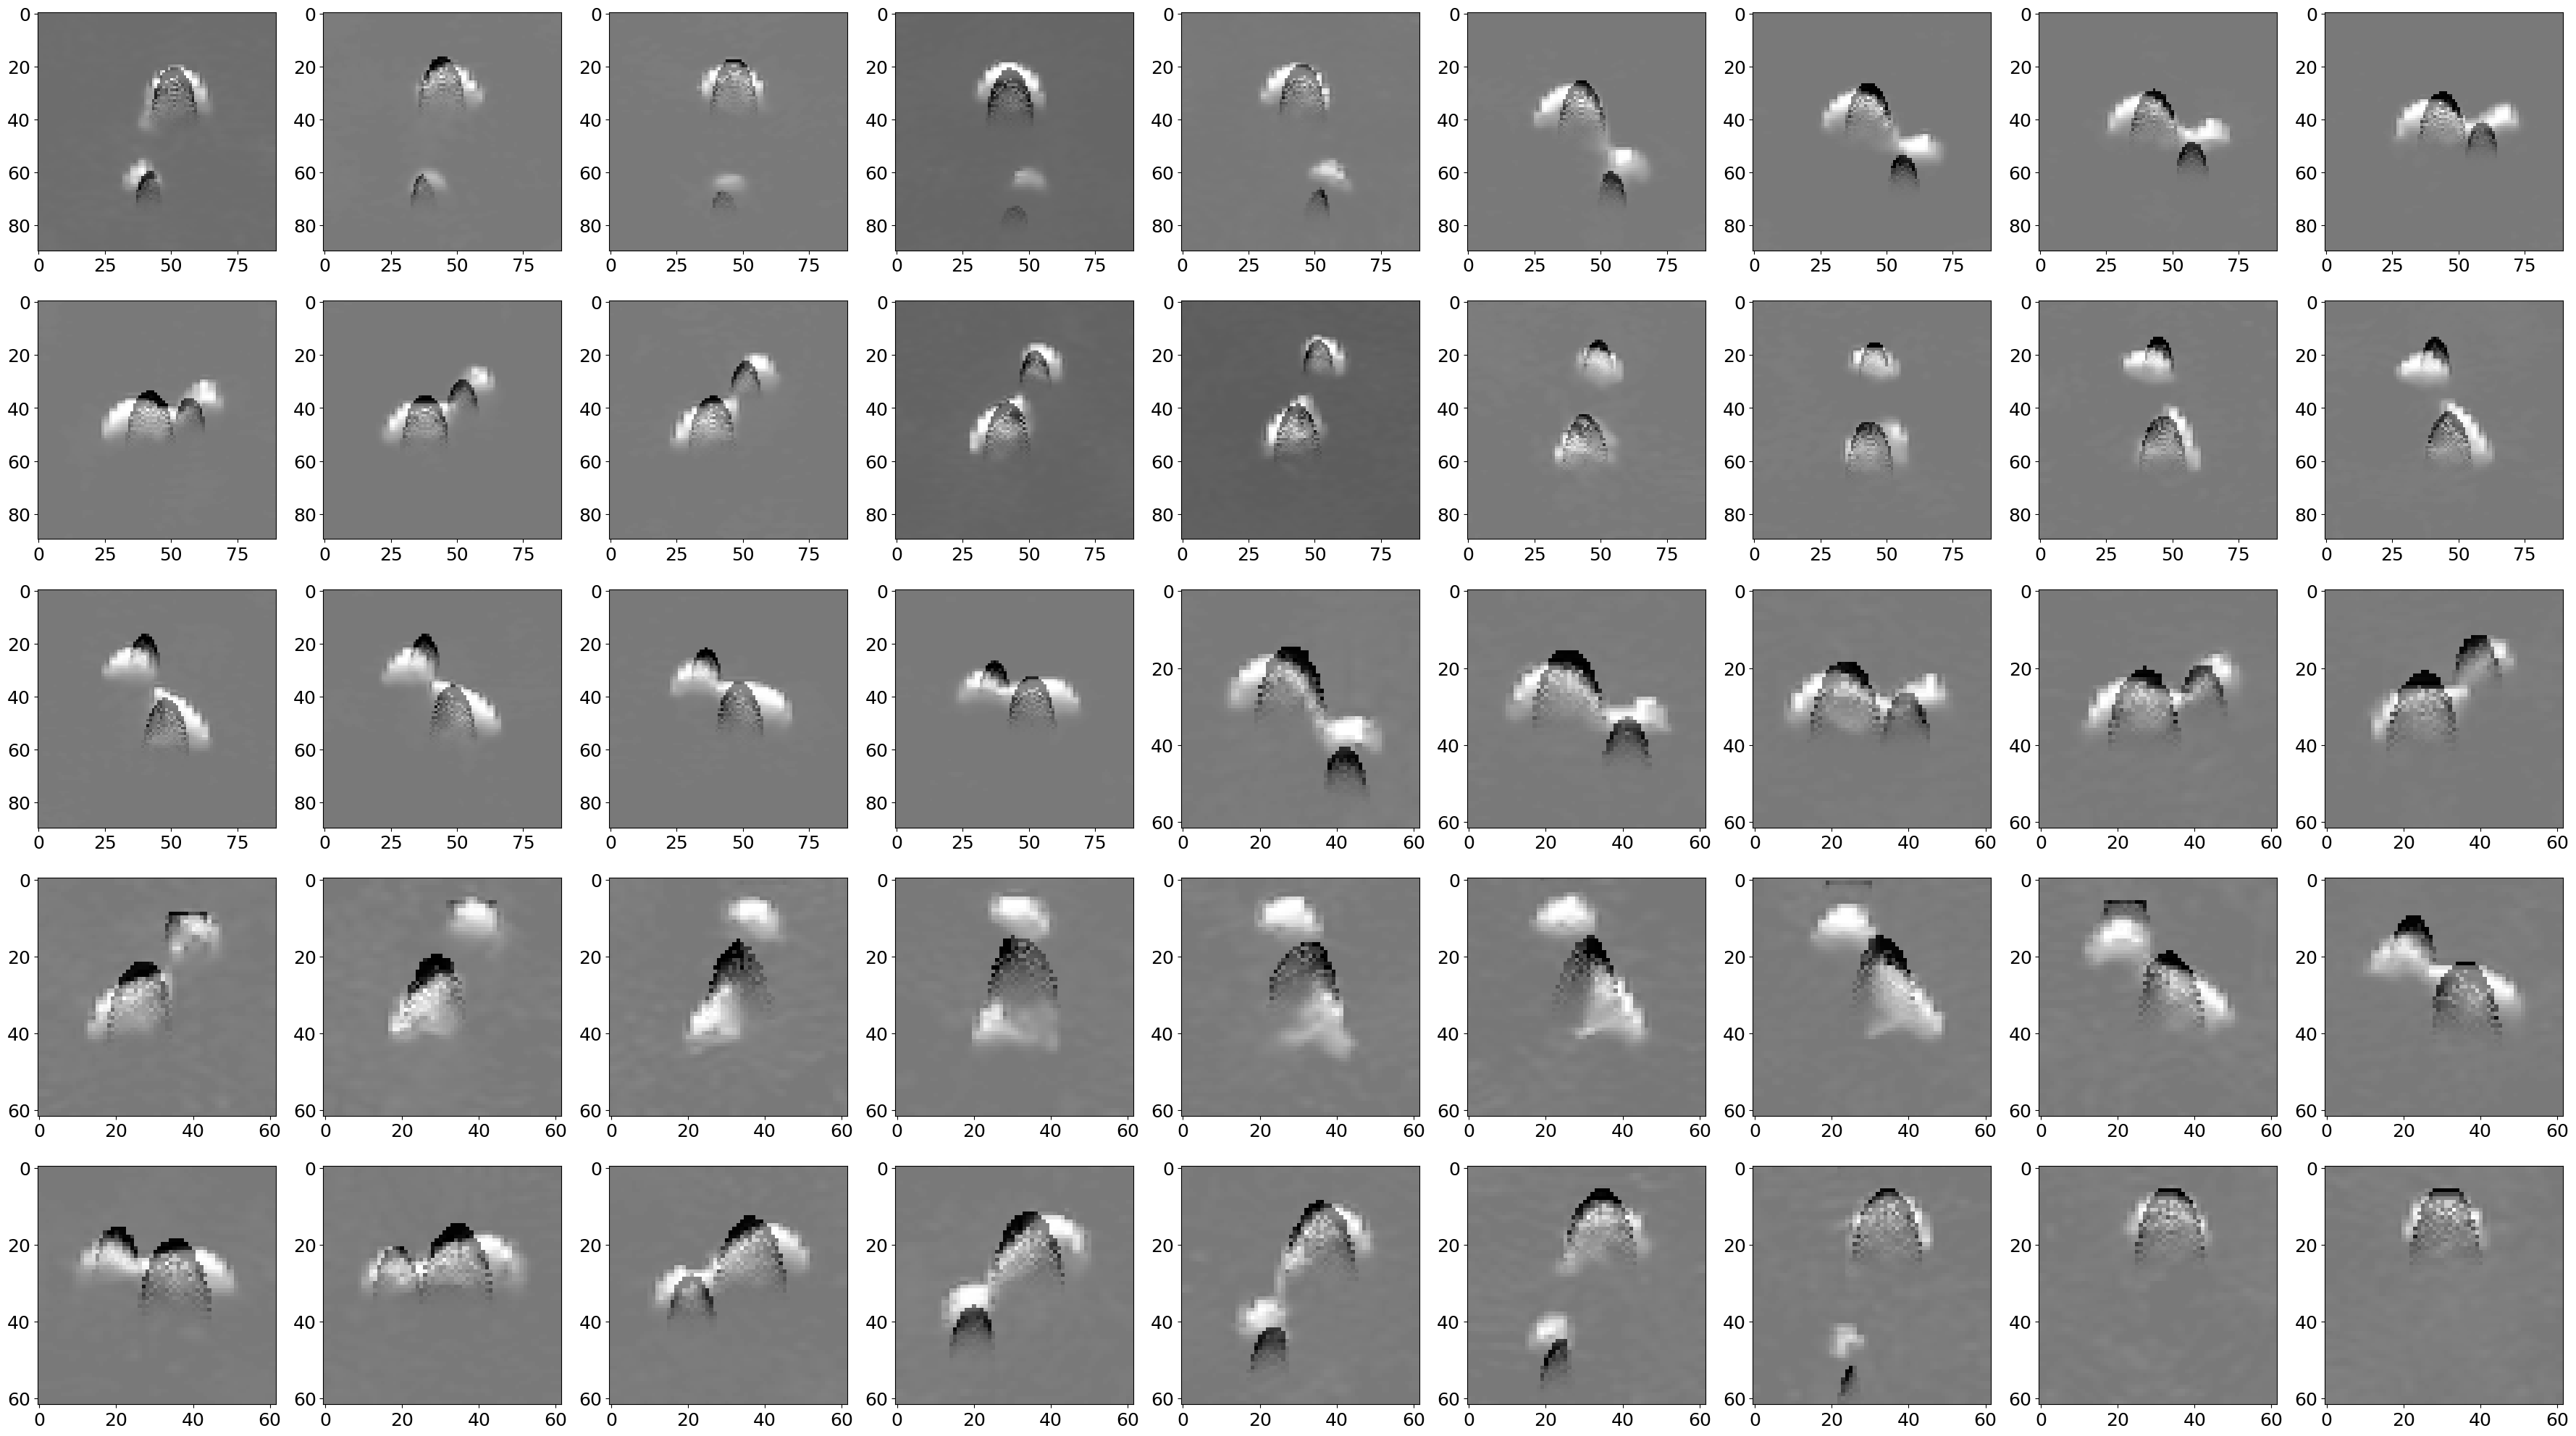

In [33]:
rows = 5
cols = 9
fig, axarr = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
for idx_img in range(0, 45):
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[idx_img // cols][idx_img % cols].imshow(imgs[idx_img], cmap='gray', interpolation='nearest')
plt.show()

In [19]:
def calc_imgs_diff(params, mult=200, radar_image_list=radar_image_params, radar_images=radar_images_obs):
     # initialize parameters
    ps = Parameters()
    ps.a1 = params[0] * mult
    ps.b1 = params[1] * mult
    ps.c1 = params[2] * mult
    ps.a2 = params[3] * mult
    ps.b2 = params[4] * mult
    ps.c2 = params[5] * mult
    ps.l = params[6]
    ps.b = params[7]
    ps.phi0 = params[8]
    # create ellipsoids
    primary = Ellipsoid(ps.a1, ps.b1, ps.c1,
                        -(ps.a1+ps.a2) *ps.a2*ps.b2*ps.c2 / (ps.a1*ps.b1*ps.c1+ps.a2*ps.b2*ps.c2))
    secondary = Ellipsoid(ps.a1, ps.b1, ps.c1, 
                        -(ps.a1+ps.a2) *ps.a1*ps.b1*ps.c1 / (ps.a1*ps.b1*ps.c1+ps.a2*ps.b2*ps.c2))
    
    cosl = math.cos(ps.l)
    sinl = math.sin(ps.l)
    cosb = math.cos(ps.b)
    sinb = math.sin(ps.b)

    
    imgs = []
    for idx_img in range(0, 71):
        if radar_image_list.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_list.jd[idx_img]-59185.77807)/ps.P + ps.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images[idx_img]
            theoretical_radar_brightness = theoretical_radar_image(primary=primary,
                                                                    secondary=secondary,
                                                                    ex=ex, ey=ey, ez=ez,
                                                                    P=ps.P, 
                                                                    N_radar_pixels=radar_image_list.size_px[idx_img],
                                                                    dr=radar_image_list.dr[idx_img], 
                                                                    dnu=radar_image_list.dnu[idx_img], Nalpha=50)
            theoretical_radar_brightness = saturate_theoretical_radar_image(theoretical_radar_brightness)
            theoretical_radar_brightness = np.array(theoretical_radar_brightness) - 0.1
            theoretical_radar_brightness /= np.max(theoretical_radar_brightness)
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness)
            x_center_theor, y_center_theor = scipy.ndimage.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = scipy.ndimage.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            #print(shift_x, shift_y)
            imgs.append(observed_radar_brightness-theoretical_radar_brightness)
    return imgs
    

In [20]:
best_params = [1, 0.426, 0.267, 0.541, 0.539, 0.539, 5.013, -1.349, 5.425] # new constrain (10k samples)
imgs_diff = calc_imgs_diff(params=best_params, mult=400)
num_imgs = len(imgs_diff)

IndexError: index 5 is out of bounds for axis 0 with size 5

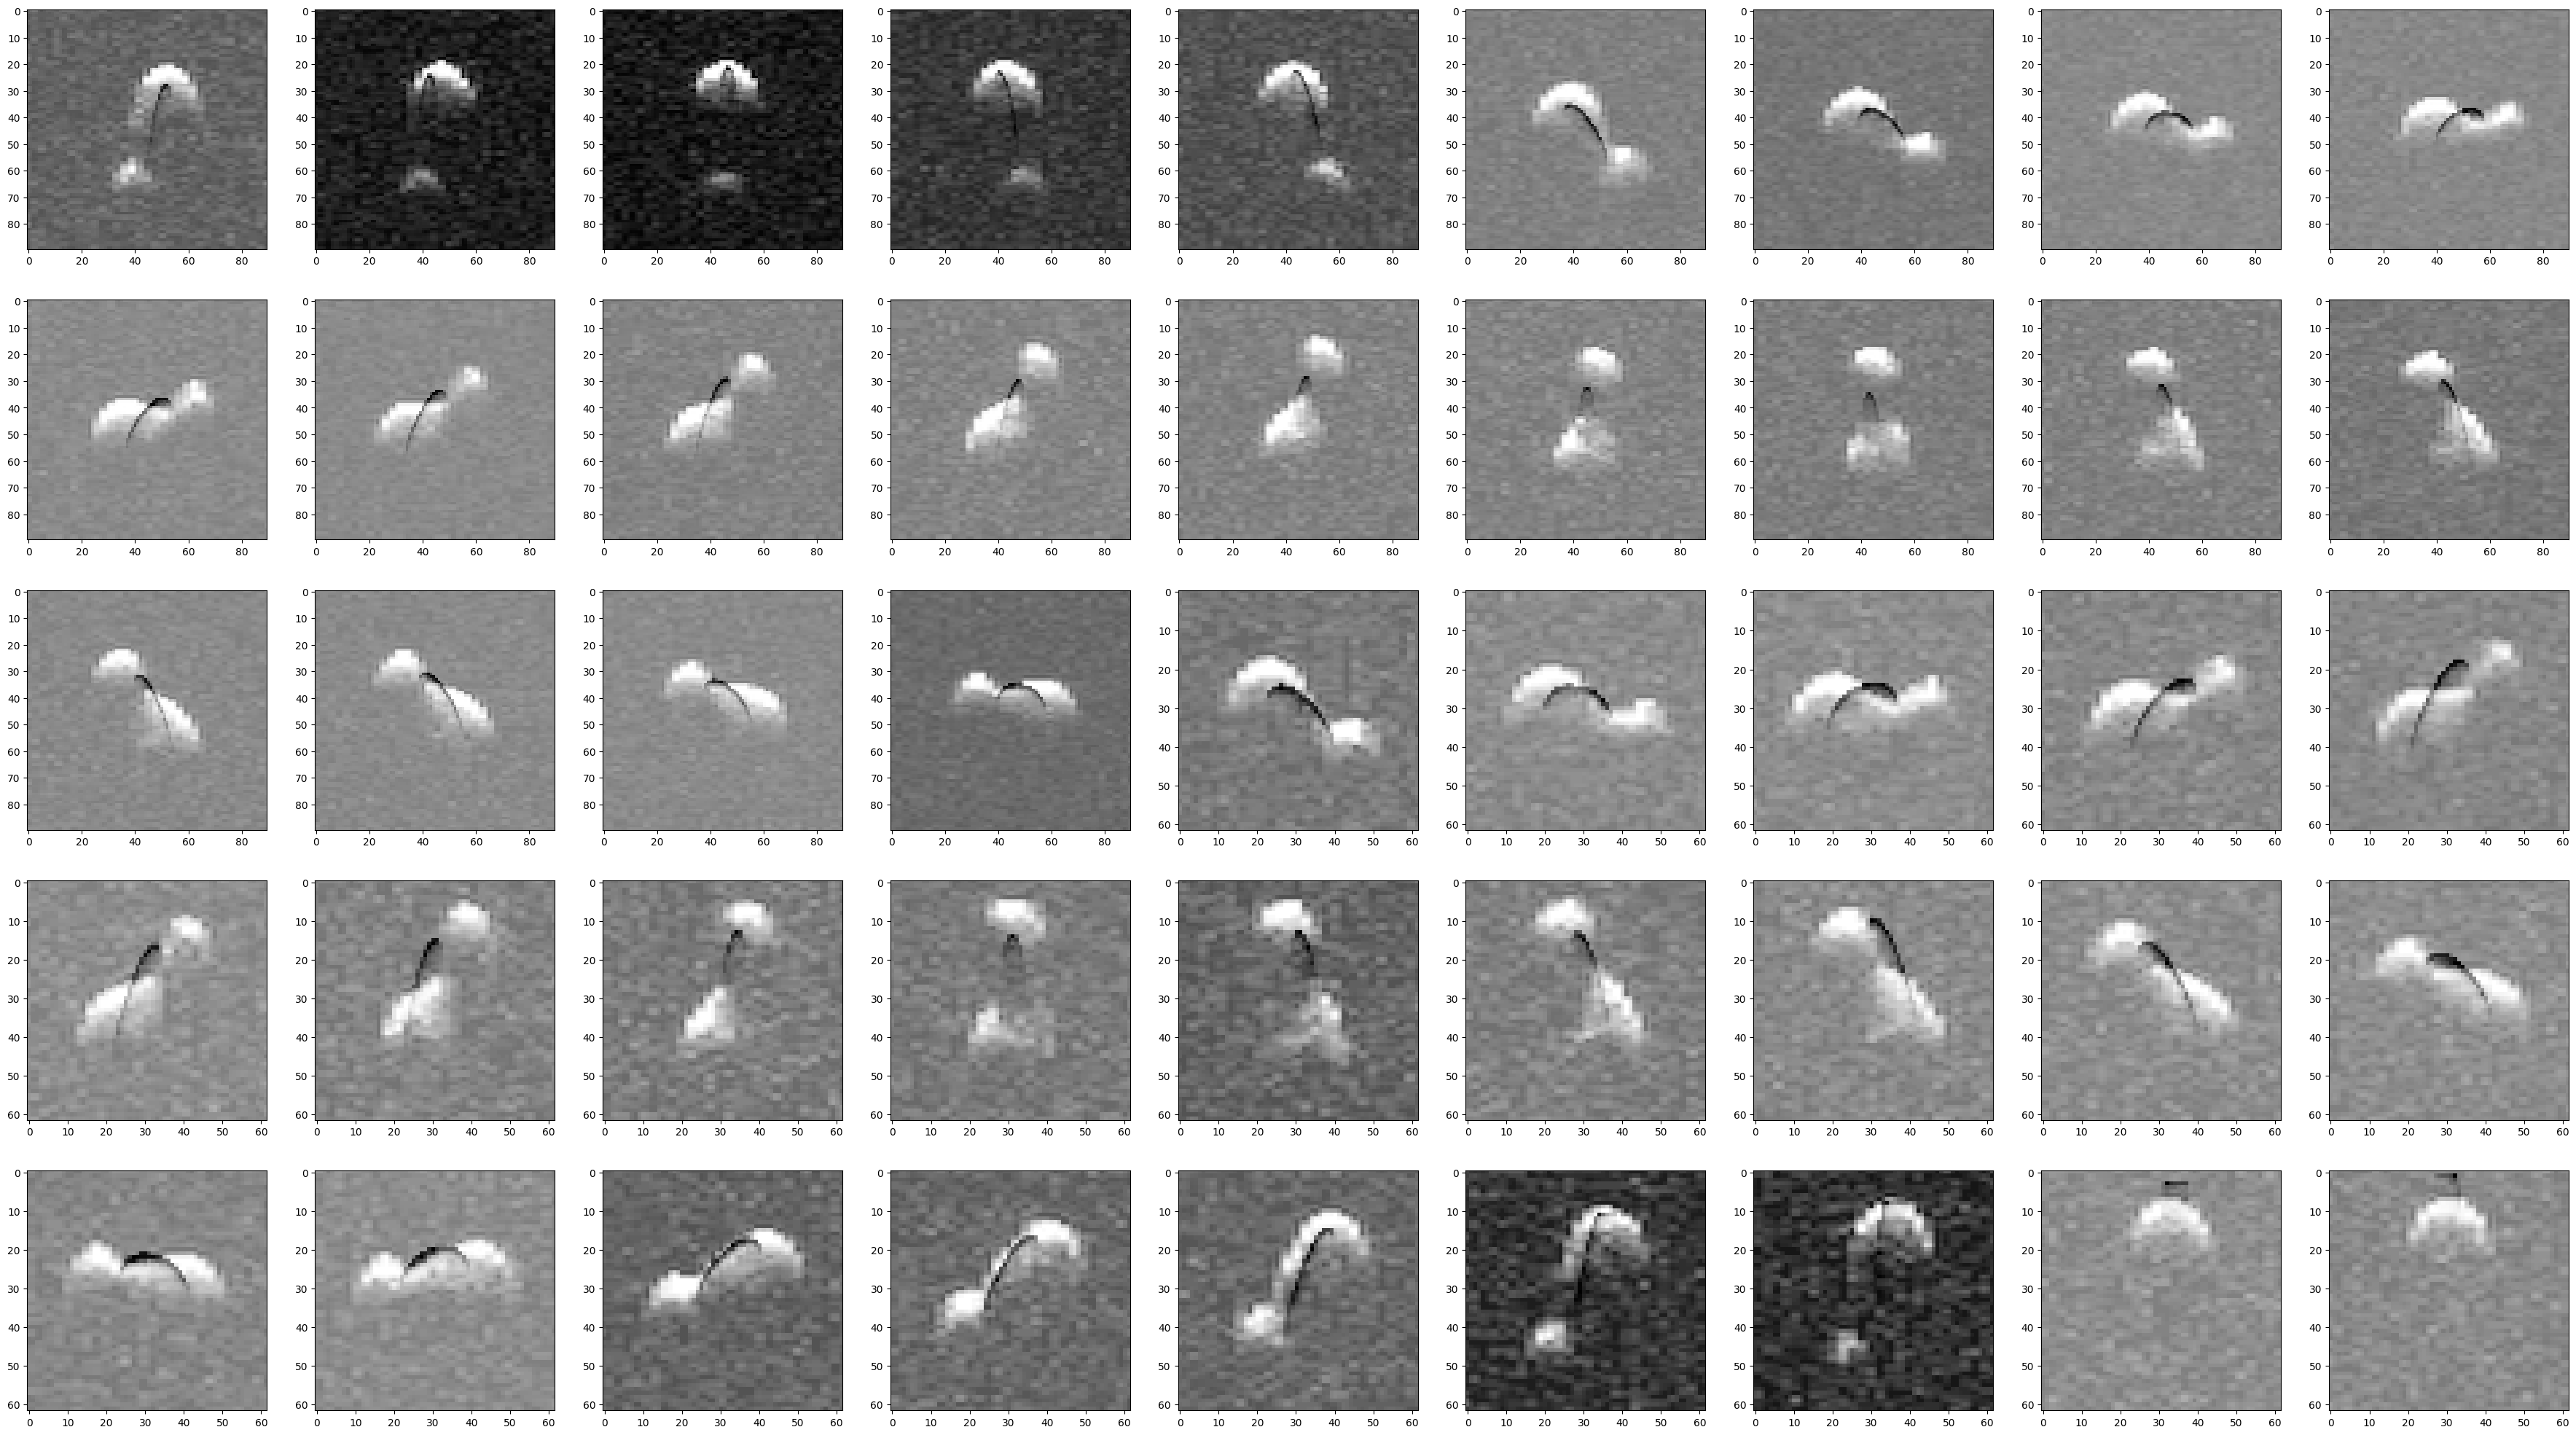

In [21]:
rows = 5
cols = 9
fig, axarr = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
for idx_img in range(0, num_imgs):
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[idx_img // cols][idx_img % cols].imshow(imgs_diff[idx_img], cmap='gray', interpolation='nearest')
plt.show()